In [30]:
import math
import collections
import urllib.request

import numpy as np
import pandas as pd
import pdfkit as pdf


from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from datetime import date
%matplotlib inline

In [2]:
pd.options.display.max_rows = 16

In [3]:
canada = pd.read_csv('canada.csv')

In [4]:
len(canada)

8922

In [5]:
canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8922 entries, 0 to 8921
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pruid                8922 non-null   int64  
 1   prname               8922 non-null   object 
 2   prnameFR             8922 non-null   object 
 3   date                 8922 non-null   object 
 4   update               3926 non-null   float64
 5   numconf              8922 non-null   int64  
 6   numprob              6312 non-null   float64
 7   numdeaths            8803 non-null   float64
 8   numtotal             8922 non-null   int64  
 9   numtested            4905 non-null   float64
 10  numtests             8922 non-null   int64  
 11  numrecover           8398 non-null   float64
 12  percentrecover       8194 non-null   float64
 13  ratetested           4566 non-null   float64
 14  ratetests            8258 non-null   float64
 15  numtoday             8922 non-null   i

In [6]:
canada.head()

,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Dropping all redundant columns

In [5]:
redundant_columns = ['prname','prnameFR','update','numtotal','numprob','numconf','numdeaths','numtested','numtests','numrecover','percentrecover','ratetested','ratetests','percentoday','ratetotal','ratedeaths','percentdeath','numtestedtoday','percentactive','numactive','rateactive','numtotal_last14','ratetotal_last14','numdeaths_last14','ratedeaths_last14','numtotal_last7','ratetotal_last7','numdeaths_last7','ratedeaths_last7','avgtotal_last7','avgincidence_last7','avgdeaths_last7','avgratedeaths_last7','raterecovered']

In [6]:
canada.drop(redundant_columns, axis=1, inplace=True)

In [7]:
canada.head()

,pruid,date,numtoday,numdeathstoday,numteststoday,numrecoveredtoday
0,35,2020-01-31,3,0.0,NaN,NaN
1,59,2020-01-31,1,0.0,NaN,NaN
2,1,2020-01-31,4,0.0,NaN,NaN
3,35,2020-02-08,0,0.0,NaN,NaN
4,59,2020-02-08,3,0.0,NaN,NaN


## Canada Lockdown Date

In [8]:
canadaLockdownDate = pd.read_csv('canada-updated-lockdwon-date.csv')

In [9]:
canadaLockdownDate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pruid   160 non-null    float64
 1   date    160 non-null    object 
 2   Class   160 non-null    float64
dtypes: float64(2), object(1)
memory usage: 34.3+ KB


In [10]:
canadaLockdownDate.head()

,pruid,date,Class
0,1.0,2020-03-15,1.0
1,1.0,2020-05-01,0.0
2,1.0,2020-11-30,1.0
3,1.0,2020-12-18,0.0
4,1.0,2021-02-28,1.0


In [11]:
canadaLockdownDate['date'] = pd.to_datetime(canadaLockdownDate['date'])

In [13]:
canadaLockdownDate.head()

,pruid,date,Class
0,1.0,2020-03-15,1.0
1,1.0,2020-05-01,0.0
2,1.0,2020-11-30,1.0
3,1.0,2020-12-18,0.0
4,1.0,2021-02-28,1.0


In [12]:
def expand_dates(ser):
    return pd.DataFrame({'date': pd.date_range(ser['date'].min(), date.today(), freq='D')})

newlockdownDF = canadaLockdownDate.groupby(['pruid']).apply(expand_dates).reset_index()\
          .merge(canadaLockdownDate, how='left')[['pruid', 'date', 'Class']].ffill()

In [15]:
newlockdownDF.head()

,pruid,date,Class
0,1.0,2020-03-15,1.0
1,1.0,2020-03-16,1.0
2,1.0,2020-03-17,1.0
3,1.0,2020-03-18,1.0
4,1.0,2020-03-19,1.0


## Joining Canada Data and Canada Lockdown Date From Government

In [13]:
canada['date'] = pd.to_datetime(canada['date'])

In [14]:
bothDF = pd.merge(canada,newlockdownDF, how='left',left_on=['pruid','date'], right_on = ['pruid','date'])

In [15]:
bothDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 8927
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pruid              8928 non-null   int64         
 1   date               8928 non-null   datetime64[ns]
 2   numtoday           8928 non-null   int64         
 3   numdeathstoday     8809 non-null   float64       
 4   numteststoday      8856 non-null   float64       
 5   numrecoveredtoday  8404 non-null   float64       
 6   Class              7587 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 558.0 KB


In [19]:
bothDF.head(n=300)

,pruid,date,numtoday,numdeathstoday,numteststoday,numrecoveredtoday,Class
0,35,2020-01-31,3,0.0,NaN,NaN,NaN
1,59,2020-01-31,1,0.0,NaN,NaN,NaN
2,1,2020-01-31,4,0.0,NaN,NaN,NaN
3,35,2020-02-08,0,0.0,NaN,NaN,NaN
4,59,2020-02-08,3,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
295,99,2020-03-26,0,0.0,0.0,NaN,NaN
296,1,2020-03-26,634,4.0,10911.0,230.0,1.0
297,59,2020-03-27,0,0.0,2754.0,0.0,1.0
298,48,2020-03-27,56,0.0,1645.0,0.0,1.0


## Replacing NaN by 0

In [16]:
bothDF.fillna(value=0, inplace=True)

In [17]:
bothDF.head()

,pruid,date,numtoday,numdeathstoday,numteststoday,numrecoveredtoday,Class
0,35,2020-01-31,3,0.0,0.0,0.0,0.0
1,59,2020-01-31,1,0.0,0.0,0.0,0.0
2,1,2020-01-31,4,0.0,0.0,0.0,0.0
3,35,2020-02-08,0,0.0,0.0,0.0,0.0
4,59,2020-02-08,3,0.0,0.0,0.0,0.0


## converting date string to python date object

## converting date to number

In [18]:
bothDF["date"] = pd.to_datetime(bothDF["date"]).dt.strftime("%Y%m%d")

In [19]:
#Grouping and applying rolling Median
bothDF['median_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(15, 1).median())
bothDF['median_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(15, 1).median())
bothDF['median_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(15, 1).median())
bothDF['median_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(15, 1).median())

In [20]:
#Grouping and applying rolling standard deviation
bothDF['std_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(15, 1).std())
bothDF['std_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(15, 1).std())
bothDF['std_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(15, 1).std())
bothDF['std_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(15, 1).std())

In [21]:
#Grouping and applying rolling variance
bothDF['var_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(15, 1).var())
bothDF['var_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(15, 1).var())
bothDF['var_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(15, 1).var())
bothDF['var_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(15, 1).var())

In [22]:
#Grouping and applying rolling skewness
bothDF['skew_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(15, 1).skew())
bothDF['skew_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(15, 1).skew())
bothDF['skew_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(15, 1).skew())
bothDF['skew_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(15, 1).skew())

In [23]:
#Grouping and applying rolling kurtosis
bothDF['kurt_numtoday'] = bothDF.groupby('pruid')['numtoday'].transform(lambda x: x.rolling(15, 1).kurt())
bothDF['kurt_numdeathstoday'] = bothDF.groupby('pruid')['numdeathstoday'].transform(lambda x: x.rolling(15, 1).kurt())
bothDF['kurt_numteststoday'] = bothDF.groupby('pruid')['numteststoday'].transform(lambda x: x.rolling(15, 1).kurt())
bothDF['kurt_numrecoveredtoday'] = bothDF.groupby('pruid')['numrecoveredtoday'].transform(lambda x: x.rolling(15, 1).kurt())

In [24]:
bothDF.head()

,pruid,date,numtoday,numdeathstoday,numteststoday,numrecoveredtoday,Class,median_numtoday,median_numdeathstoday,median_numteststoday,...,var_numteststoday,var_numrecoveredtoday,skew_numtoday,skew_numdeathstoday,skew_numteststoday,skew_numrecoveredtoday,kurt_numtoday,kurt_numdeathstoday,kurt_numteststoday,kurt_numrecoveredtoday
0,35,20200131,3,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,20200131,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,20200131,4,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35,20200208,0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,20200208,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
bothDF.drop(['numtoday','numdeathstoday','numteststoday','numrecoveredtoday'], axis=1, inplace=True)

In [26]:
for i, (name, group) in enumerate(bothDF.groupby('pruid')):
    group.to_csv('lockdown-{}.csv'.format(i))

In [27]:
alberta = pd.read_csv('lockdown-9.csv')

In [37]:
britishColumbia = pd.read_csv('lockdown-10.csv')

In [34]:
alberta.head()

,Unnamed: 0,pruid,date,Class,median_numtoday,median_numdeathstoday,median_numteststoday,median_numrecoveredtoday,std_numtoday,std_numdeathstoday,...,var_numteststoday,var_numrecoveredtoday,skew_numtoday,skew_numdeathstoday,skew_numteststoday,skew_numrecoveredtoday,kurt_numtoday,kurt_numdeathstoday,kurt_numteststoday,kurt_numrecoveredtoday
0,50,48,20200308,0.0,1.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,48,20200309,0.0,3.5,0.0,0.0,0.0,3.535534,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58,48,20200311,0.0,6.0,0.0,0.0,0.0,3.214550,0.0,...,0.0,0.0,-1.545393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73,48,20200312,0.0,5.5,0.0,0.0,0.0,2.629956,0.0,...,153664.0,0.0,-1.443059,NaN,2.000000,NaN,2.234867,NaN,4.000000,NaN
4,88,48,20200313,0.0,5.0,0.0,0.0,0.0,2.302173,0.0,...,374256.8,0.0,-1.032659,NaN,1.043405,NaN,1.128513,NaN,-0.856871,NaN


In [35]:
alberta.drop(['Unnamed: 0'], axis=1, inplace=True)

In [38]:
britishColumbia.drop(['Unnamed: 0'], axis=1, inplace=True)

In [28]:
alberta.to_html('Alberta.html')

In [40]:
alberta.to_excel("Alberta.xlsx") 

In [31]:
pdf.from_file('Alberta.html', 'Alberta.pdf')

True

In [41]:
britishColumbia.to_excel("britishColumbia.xlsx") 

In [30]:
bothDF.to_csv('subcolumn-data.csv',encoding='utf-8-sig')

In [46]:
bothDF.head()

,pruid,date,Class,median_numtoday,median_numdeathstoday,median_numteststoday,median_numrecoveredtoday,std_numtoday,std_numdeathstoday,std_numteststoday,...,var_numteststoday,var_numrecoveredtoday,skew_numtoday,skew_numdeathstoday,skew_numteststoday,skew_numrecoveredtoday,kurt_numtoday,kurt_numdeathstoday,kurt_numteststoday,kurt_numrecoveredtoday
0,35,20200131,0.0,3.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,20200131,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,20200131,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35,20200208,0.0,1.5,0.0,0.0,0.0,2.121320,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,20200208,0.0,2.0,0.0,0.0,0.0,1.414214,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
bothDF.fillna(value=0, inplace=True)

In [48]:
bothDF.head()

,pruid,date,Class,median_numtoday,median_numdeathstoday,median_numteststoday,median_numrecoveredtoday,std_numtoday,std_numdeathstoday,std_numteststoday,...,var_numteststoday,var_numrecoveredtoday,skew_numtoday,skew_numdeathstoday,skew_numteststoday,skew_numrecoveredtoday,kurt_numtoday,kurt_numdeathstoday,kurt_numteststoday,kurt_numrecoveredtoday
0,35,20200131,0.0,3.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,20200131,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,20200131,0.0,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35,20200208,0.0,1.5,0.0,0.0,0.0,2.121320,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,20200208,0.0,2.0,0.0,0.0,0.0,1.414214,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
labels = bothDF["Class"]

In [49]:
for i, (name, group) in enumerate(bothDF.groupby('pruid')):
    group.to_csv('lockdwon-{}.csv'.format(i))

In [35]:
both_tsne= bothDF.copy()

In [36]:
both_tsne.drop('Class', axis=1, inplace=True)

In [37]:
both_tsne

,pruid,date,numtoday,numdeathstoday,numteststoday,numrecoveredtoday,median_numtoday,median_numdeathstoday,median_numteststoday,median_numrecoveredtoday,...,var_numteststoday,var_numrecoveredtoday,skew_numtoday,skew_numdeathstoday,skew_numteststoday,skew_numrecoveredtoday,kurt_numtoday,kurt_numdeathstoday,kurt_numteststoday,kurt_numrecoveredtoday
0,35,20200131,3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,20200131,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,20200131,4,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35,20200208,0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,20200208,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,60,20211022,0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,...,3.142629e-12,4.000000e+01,2.012204,NaN,NaN,1.550081,3.618924,NaN,NaN,1.772253
8924,61,20211022,17,0.0,84.0,15.0,21.0,0.0,84.0,18.0,...,1.038781e+03,3.308924e+03,0.564165,2.918888,0.642540,2.151974,-0.399727,8.388430,0.873557,4.196933
8925,62,20211022,0,0.0,46.0,0.0,0.0,0.0,41.0,0.0,...,3.772667e+02,8.380952e-01,2.286472,NaN,0.682988,2.046207,4.737925,NaN,0.498122,3.646297
8926,99,20211022,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
both_tsne.fillna(value=0, inplace=True)

In [50]:
newfoundlandd = pd.read_csv('lockdwon-1.csv')
prince_edward = pd.read_csv('lockdwon-2.csv')
novascotia = pd.read_csv('lockdwon-3.csv')
new_brunswick = pd.read_csv('lockdwon-4.csv')
quebec = pd.read_csv('lockdwon-5.csv')
ontario = pd.read_csv('lockdwon-6.csv')
manitoba = pd.read_csv('lockdwon-7.csv')
saskatchewan = pd.read_csv('lockdwon-8.csv')
alberta = pd.read_csv('lockdwon-9.csv')
british = pd.read_csv('lockdwon-10.csv')
yukon = pd.read_csv('lockdwon-11.csv')
nunavut = pd.read_csv('lockdwon-13.csv')

In [52]:
newfoundlandd.drop(['Unnamed: 0'], axis=1, inplace=True)
prince_edward.drop(['Unnamed: 0'], axis=1, inplace=True)
novascotia.drop(['Unnamed: 0'], axis=1, inplace=True)
new_brunswick.drop(['Unnamed: 0'], axis=1, inplace=True)
quebec.drop(['Unnamed: 0'], axis=1, inplace=True)
ontario.drop(['Unnamed: 0'], axis=1, inplace=True)
manitoba.drop(['Unnamed: 0'], axis=1, inplace=True)
saskatchewan.drop(['Unnamed: 0'], axis=1, inplace=True)
alberta.drop(['Unnamed: 0'], axis=1, inplace=True)
british.drop(['Unnamed: 0'], axis=1, inplace=True)
yukon.drop(['Unnamed: 0'], axis=1, inplace=True)
nunavut.drop(['Unnamed: 0'], axis=1, inplace=True)

In [54]:
newflabels = newfoundlandd["Class"]
pelabels = prince_edward["Class"]
nslabels = novascotia["Class"]
nblabels = new_brunswick["Class"]
qlabels = quebec["Class"]
olabels = ontario["Class"]
mlabels = manitoba["Class"]
slabels = saskatchewan["Class"]
alabels = alberta["Class"]
blabels = british["Class"]
ylabels = yukon["Class"]
nulabels = nunavut["Class"]

In [55]:
newfoundlandd.drop(['Class'], axis=1, inplace=True)
prince_edward.drop(['Class'], axis=1, inplace=True)
novascotia.drop(['Class'], axis=1, inplace=True)
new_brunswick.drop(['Class'], axis=1, inplace=True)
quebec.drop(['Class'], axis=1, inplace=True)
ontario.drop(['Class'], axis=1, inplace=True)
manitoba.drop(['Class'], axis=1, inplace=True)
saskatchewan.drop(['Class'], axis=1, inplace=True)
alberta.drop(['Class'], axis=1, inplace=True)
british.drop(['Class'], axis=1, inplace=True)
yukon.drop(['Class'], axis=1, inplace=True)
nunavut.drop(['Class'], axis=1, inplace=True)

In [57]:
tsne = TSNE(n_components=2, random_state=0)
new_obj = tsne.fit_transform(newfoundlandd)
pr_obj = tsne.fit_transform(prince_edward)
ns_obj = tsne.fit_transform(novascotia)
nb_obj = tsne.fit_transform(new_brunswick)
qb_obj = tsne.fit_transform(quebec)
on_obj = tsne.fit_transform(ontario)
ma_obj = tsne.fit_transform(manitoba)
sa_obj = tsne.fit_transform(saskatchewan)
ab_obj = tsne.fit_transform(alberta)
br_obj = tsne.fit_transform(british)
yu_obj = tsne.fit_transform(yukon)
nu_obj = tsne.fit_transform(nunavut)

In [58]:
new_tsne = pd.DataFrame({'X':new_obj[:,0],
                        'Y':new_obj[:,1],
                           'cluster':newflabels})
pr_tsne = pd.DataFrame({'X':pr_obj[:,0],
                        'Y':pr_obj[:,1],
                           'cluster':pelabels})
ns_tsne = pd.DataFrame({'X':ns_obj[:,0],
                        'Y':ns_obj[:,1],
                           'cluster':nslabels})
nb_tsne = pd.DataFrame({'X':nb_obj[:,0],
                        'Y':nb_obj[:,1],
                           'cluster':nblabels})
qb_tsne = pd.DataFrame({'X':qb_obj[:,0],
                        'Y':qb_obj[:,1],
                           'cluster':qlabels})
on_tsne = pd.DataFrame({'X':on_obj[:,0],
                        'Y':on_obj[:,1],
                           'cluster':olabels})
ma_tsne = pd.DataFrame({'X':ma_obj[:,0],
                        'Y':ma_obj[:,1],
                           'cluster':mlabels})
sa_tsne = pd.DataFrame({'X':sa_obj[:,0],
                        'Y':sa_obj[:,1],
                           'cluster':slabels})
ab_tsne = pd.DataFrame({'X':ab_obj[:,0],
                        'Y':ab_obj[:,1],
                           'cluster':alabels})
br_tsne = pd.DataFrame({'X':br_obj[:,0],
                        'Y':br_obj[:,1],
                           'cluster':blabels})
y_tsne = pd.DataFrame({'X':yu_obj[:,0],
                        'Y':yu_obj[:,1],
                           'cluster':ylabels})
nu_tsne = pd.DataFrame({'X':nu_obj[:,0],
                        'Y':nu_obj[:,1],
                           'cluster':nulabels})

Text(0.5, 1.0, 'Provinces-TSNE')

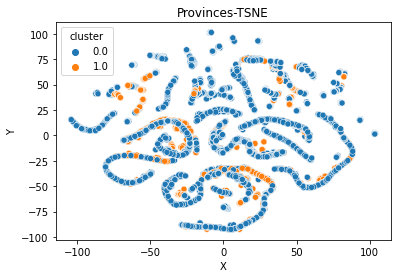

In [72]:
sns.scatterplot(x="X", y="Y",
              data=t_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Provinces-TSNE")

Text(0.5, 1.0, 'Newfoundland-TSNE')

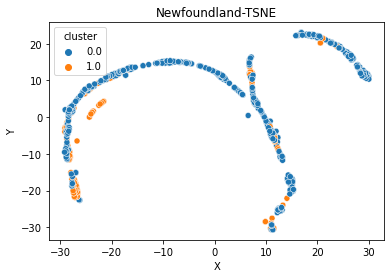

In [60]:
sns.scatterplot(x="X", y="Y",
              data=new_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Newfoundland-TSNE")

Text(0.5, 1.0, 'PrinceEdward-TSNE')

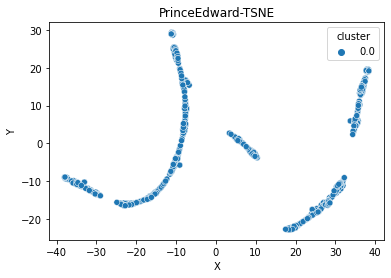

In [61]:
sns.scatterplot(x="X", y="Y",
              data=pr_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("PrinceEdward-TSNE")

Text(0.5, 1.0, 'NovaScotia-TSNE')

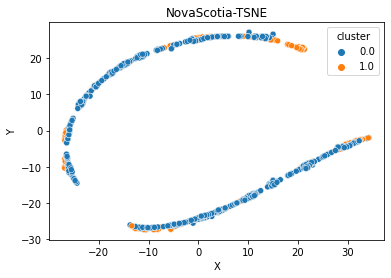

In [62]:
sns.scatterplot(x="X", y="Y",
              data=ns_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("NovaScotia-TSNE")

Text(0.5, 1.0, 'NewBrunswick-TSNE')

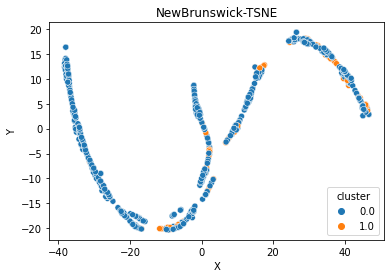

In [63]:
sns.scatterplot(x="X", y="Y",
              data=nb_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("NewBrunswick-TSNE")

Text(0.5, 1.0, 'Quebec-TSNE')

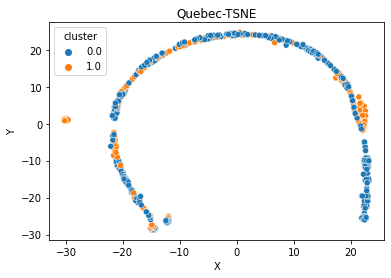

In [64]:
sns.scatterplot(x="X", y="Y",
              data=qb_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Quebec-TSNE")

Text(0.5, 1.0, 'Ontario-TSNE')

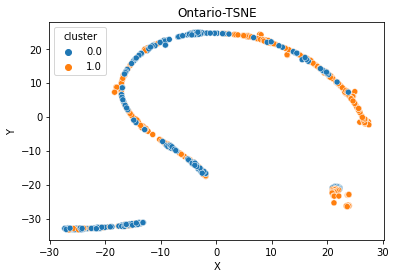

In [65]:
sns.scatterplot(x="X", y="Y",
              data=on_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Ontario-TSNE")

Text(0.5, 1.0, 'Manitoba-TSNE')

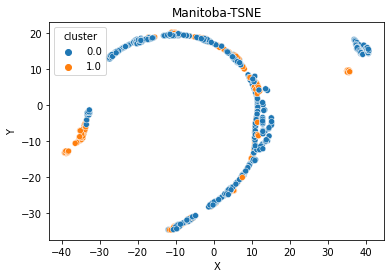

In [66]:
sns.scatterplot(x="X", y="Y",
              data=ma_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Manitoba-TSNE")

Text(0.5, 1.0, 'Saskatchewan-TSNE')

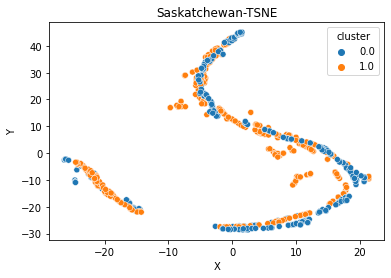

In [67]:
sns.scatterplot(x="X", y="Y",
              data=sa_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Saskatchewan-TSNE")

Text(0.5, 1.0, 'Alberta-TSNE')

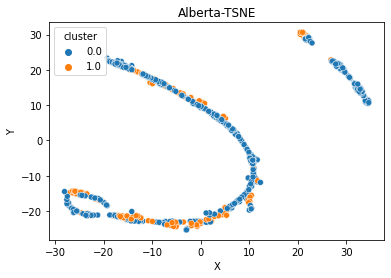

In [68]:
sns.scatterplot(x="X", y="Y",
              data=ab_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Alberta-TSNE")

Text(0.5, 1.0, 'British-TSNE')

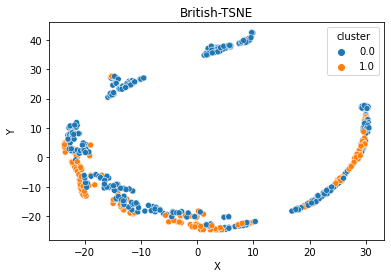

In [69]:
sns.scatterplot(x="X", y="Y",
              data=br_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("British-TSNE")

Text(0.5, 1.0, 'Yukon-TSNE')

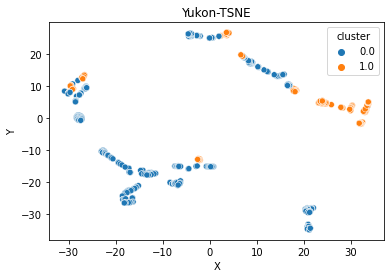

In [70]:
sns.scatterplot(x="X", y="Y",
              data=y_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Yukon-TSNE")

Text(0.5, 1.0, 'Nunavut-TSNE')

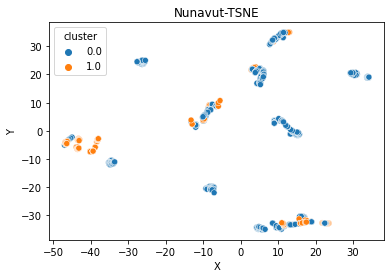

In [71]:
sns.scatterplot(x="X", y="Y",
              data=nu_tsne,
              hue='cluster',
              legend="full")
ax = plt.gca()
ax.set_title("Nunavut-TSNE")